##### Copyright 2018 The TensorFlow Authors.

In [55]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [56]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa

tfds.disable_progress_bar()
np.set_printoptions(precision=3, suppress=True)

Import `matplotlib` and create a helper function to plot graphs:

In [57]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


[4163, 20620]


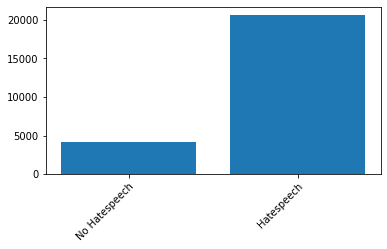

<Figure size 1152x720 with 0 Axes>

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#
# Load the csv data.
#
def load_data_arrays():
    data_path = "datasets/1_no_stopwords.csv"
    df = pd.read_csv(data_path)

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["No Hatespeech", "Hatespeech"],
               rotation=45,
               rotation_mode="anchor",
               ha="right")

    plt.subplots_adjust(bottom=0.3)
    plt.figure(figsize=(16, 10))
    plt.show()

train_df, test_df = load_data_arrays()


plot_data_distribution(train_df['is_hatespeech'].values, test_df['is_hatespeech'].values)

In [59]:
# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = np.eye(2)[train_df['is_hatespeech'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(2)[test_df['is_hatespeech'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [60]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [61]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [62]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  [b'lol think it right way amp wrong way love someone hoe may love got'
 b'if nbc elected spokesman nbc lot trouble i friends longer watch nbc trash 1'
 b'bitch got flameeee'
 b'rt to call martin baker uncle tom uppity hes siding majority pure ignorance'
 b'rt rt u remember steve blue clues left us bitch ass nigga joe'
 b'spics half breed trash no filthy native allowed speak european'
 b'and u aint ho get up out my trap houuuse' b'funny u faggot'
 b'twice divorced teabagger florida attorney general says marriage reserved stable enduring family units'
 b'i cheated 10 bitches i tf lol nobody even wanted committed shit'
 b'rt hits blunt bruh tells go text hoes one hoes i keep texting'
 b'i ignore birds'
 b'rt yall makin nigga microwaveable dinner meanwhile eatin another bitch homemade dinner'
 b'rt my ex bitch keep tryna next bitch called tha day told give it a rest bitch'
 b'in many areas look need see bean countsaid before beans bitchtend expect'
 b'need one around world twitter 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [63]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [64]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'bitch', 'rt', 'i', 'bitches', 'like', 'hoes', 'im',
       'pussy', 'hoe', 'ass', 'fuck', 'get', 'shit', 'got', 'u', 'you',
       'nigga', 'aint'], dtype='<U27')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [65]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 21,  48,  42,  61, 148,  22, 250, 148,  26, 168,  10, 504,  26,
         15,   0,   0,   0,   0,   0,   0],
       [ 30,   1,   1,   1,   1, 267,   1,   4, 216,   1, 252,   1,  20,
        206,   0,   0,   0,   0,   0,   0],
       [  2,  15,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [66]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'lol think it right way amp wrong way love someone hoe may love got'
Round-trip:  lol think it right way amp wrong way love someone hoe may love got      

Original:  b'if nbc elected spokesman nbc lot trouble i friends longer watch nbc trash 1'
Round-trip:  if [UNK] [UNK] [UNK] [UNK] lot [UNK] i friends [UNK] watch [UNK] trash 1      

Original:  b'bitch got flameeee'
Round-trip:  bitch got [UNK]                 



## Create the model

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [67]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 138,434
Trainable params: 138,434
Non-tr

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [68]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [69]:
# predict on a sample text without padding.

sample_text = ('How are you doing')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.499 0.501]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [70]:
# predict on a sample text with padding

padding = "How are you doing " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.499 0.501]


Compile the Keras model to configure the training process:

In [71]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy', tfa.metrics.f_scores.F1Score(2, "micro")])

## Train the model

In [72]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/5
310/310 [==============================] - 11s 23ms/step - loss: 0.4904 - accuracy: 0.8325 - f1_score: 0.8325 - val_loss: 0.2776 - val_accuracy: 0.8687 - val_f1_score: 0.8687
Epoch 2/5
310/310 [==============================] - 6s 18ms/step - loss: 0.1911 - accuracy: 0.9208 - f1_score: 0.9208 - val_loss: 0.1572 - val_accuracy: 0.9344 - val_f1_score: 0.9344
Epoch 3/5
310/310 [==============================] - 6s 19ms/step - loss: 0.1327 - accuracy: 0.9471 - f1_score: 0.9471 - val_loss: 0.1502 - val_accuracy: 0.9438 - val_f1_score: 0.9438
Epoch 4/5
310/310 [==============================] - 6s 18ms/step - loss: 0.1178 - accuracy: 0.9556 - f1_score: 0.9556 - val_loss: 0.1502 - val_accuracy: 0.9438 - val_f1_score: 0.9438
Epoch 5/5
310/310 [==============================] - 6s 18ms/step - loss: 0.1103 - accuracy: 0.9583 - f1_score: 0.9583 - val_loss: 0.1525 - val_accuracy: 0.9391 - val_f1_score: 0.9391


In [73]:
test_loss, test_acc, test_entr = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Entropy:', test_entr)

78/78 [==============================] - 1s 9ms/step - loss: 0.1359 - accuracy: 0.9429 - f1_score: 0.9429
Test Loss: 0.13590672612190247
Test Accuracy: 0.9429090023040771
Test Entropy: 0.9429090023040771


(0.0, 0.5093838941305876)

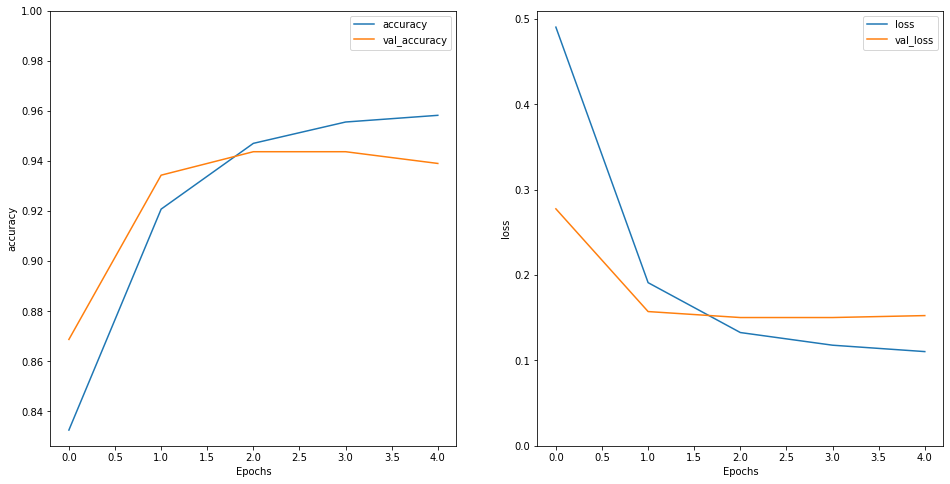

In [74]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [75]:
sample_text = ['That was very nice of you to say', 'You stupid fucking bitch']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.757 0.243]
 [0.    1.   ]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [76]:
model_two = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model_two.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                      

In [77]:
model_two.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy', tfa.metrics.f_scores.F1Score(2, "micro")])

In [78]:
history_two = model_two.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
310/310 [==============================] - 17s 35ms/step - loss: 0.4592 - accuracy: 0.8402 - f1_score: 0.8402 - val_loss: 0.2447 - val_accuracy: 0.8818 - val_f1_score: 0.8818
Epoch 2/5
310/310 [==============================] - 9s 30ms/step - loss: 0.1815 - accuracy: 0.9273 - f1_score: 0.9273 - val_loss: 0.1574 - val_accuracy: 0.9391 - val_f1_score: 0.9391
Epoch 3/5
310/310 [==============================] - 9s 30ms/step - loss: 0.1356 - accuracy: 0.9489 - f1_score: 0.9489 - val_loss: 0.1450 - val_accuracy: 0.9469 - val_f1_score: 0.9469
Epoch 4/5
310/310 [==============================] - 9s 30ms/step - loss: 0.1191 - accuracy: 0.9558 - f1_score: 0.9558 - val_loss: 0.1433 - val_accuracy: 0.9479 - val_f1_score: 0.9479
Epoch 5/5
310/310 [==============================] - 9s 30ms/step - loss: 0.1119 - accuracy: 0.9597 - f1_score: 0.9597 - val_loss: 0.1450 - val_accuracy: 0.9484 - val_f1_score: 0.9484


In [79]:
test_loss, test_acc, test_entr = model_two.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Entropy:', test_entr)

78/78 [==============================] - 1s 15ms/step - loss: 0.1419 - accuracy: 0.9431 - f1_score: 0.9431
Test Loss: 0.14192712306976318
Test Accuracy: 0.9431107640266418
Test Entropy: 0.9431107640266418


In [82]:
# predict on a sample text without padding.

sample_text = ['You are such a stupid fucking whore',
               'I would not recommend this movie.']
predictions = model_two.predict(np.array(sample_text))

print(predictions)

[[0.    1.   ]
 [0.743 0.257]]


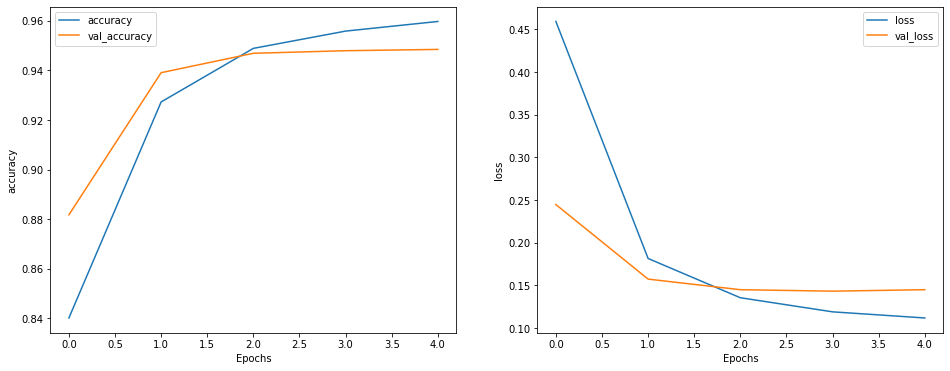

In [81]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_two, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_two, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
